In [37]:
%matplotlib inline
import os
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio import features
from affine import Affine
import warnings
warnings.filterwarnings('ignore')


In [21]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))
    


In [22]:
root_dir = "/dartfs-hpc/rc/lab/C/CMIG"
data_dir = os.path.join(root_dir, "agottlieb", "snow_drought", "data")
fig_dir = os.path.join(root_dir, "agottlieb", "snow_drought", "figures")

In [23]:
# load basin boundaries
grdc_basins = gpd.read_file(os.path.join(data_dir, "etc", "grdc_basins"), layer="mrb_basins")
basin_ids = {k: i for i, k in enumerate(grdc_basins.RIVER_BASI)}
basin_shapes = [(shape, n) for n, shape in enumerate(grdc_basins.geometry)]

In [24]:
# load gridded ensemble
gridded_peak_ensemble = xr.open_dataset(os.path.join(data_dir,"ensembles","peak_ensemble.nc"))

# subset out years of common overlap
gridded_peak_ensemble = gridded_peak_ensemble.sel(time=slice("2002-10-01","2017-10-01"))
gridded_peak_ensemble = gridded_peak_ensemble.where(gridded_peak_ensemble["peak_swe"]>0)

# calculate peak SWE z-scores
gridded_peak_ensemble["peak_swe_anom"] = (gridded_peak_ensemble["peak_swe"] - gridded_peak_ensemble["peak_swe"].mean("time")) / gridded_peak_ensemble["peak_swe"].std("time")

# calculate ensemble spread-to-mean ratio at each timestep
gridded_peak_max = gridded_peak_ensemble["peak_swe"].max("product")
gridded_peak_min = gridded_peak_ensemble["peak_swe"].min("product")
gridded_peak_mean = gridded_peak_ensemble["peak_swe"].mean("product")
gridded_ens_uncert = (gridded_peak_max-gridded_peak_min) / gridded_peak_mean
gridded_ens_uncert = gridded_ens_uncert.where(gridded_ens_uncert.max("time")!=0)

In [25]:
# load basin ensemble
basin_peak_ensemble = pd.read_csv(os.path.join(data_dir,"ensembles","basin_peak_ensemble.csv"))

# subset out same years of common overlap
basin_peak_ensemble["time"] = pd.to_datetime(basin_peak_ensemble["time"])
basin_peak_ensemble = basin_peak_ensemble[(basin_peak_ensemble.time.dt.date>=pd.to_datetime("2002-10-01")) & (basin_peak_ensemble.time.dt.date<=pd.to_datetime("2017-10-01"))]

# calculate ensemble spread-to-mean ratio
basin_peak_ensemble["peak_swe"] = basin_peak_ensemble["peak_swe"].replace(0,np.nan)
basin_peak_stats = basin_peak_ensemble.groupby(["basin","time"]).agg({"peak_swe": ["max","min", "mean"]})
basin_peak_spread = (basin_peak_stats["peak_swe","max"]-basin_peak_stats["peak_swe","min"]) / basin_peak_stats["peak_swe","mean"]
basin_peak_spread.name="ensemble_uncertainty"

# merge with basins shapefile
basin_ens_uncert = basin_peak_spread.reset_index().groupby("basin").agg({"ensemble_uncertainty": "mean"})
basin_ens_uncert = gpd.GeoDataFrame(basin_ens_uncert.merge(grdc_basins[["geometry"]],left_index=True,right_index=True))
basin_ens_uncert = rasterize(zip(basin_ens_uncert.geometry,basin_ens_uncert.ensemble_uncertainty),peak_ensemble.drop(["time","product"]).coords)


In [27]:
# load stats of pairwise correlation distributions
gridded_r_ds = xr.open_dataset(os.path.join(data_dir,"ensembles","peak_spearmanr_all_prods.nc"))
gridded_r_ds = gridded_r_ds.astype(float)

basin_r = gpd.read_file(os.path.join(data_dir,"ensembles","basin_peak_spearmanr_all_products"))
basin_r.set_index("index",inplace=True)

# rasterize basin stats
basin_r_ds = rasterize(zip(basin_r.geometry,basin_r.r_mean),peak_ensemble.drop(["time","product"]).coords)
basin_r_sig = rasterize(zip(basin_r.geometry,basin_r.frac_sig),peak_ensemble.drop(["time","product"]).coords)

In [33]:
# get boundaries to indicate different numbers of products
world_borders = gpd.read_file(os.path.join(data_dir,"etc","world_borders"))
na_borders = world_borders[world_borders.ISO3.isin(["USA","MEX","CAN"])].dissolve(by="REGION") # North America (10)

us_borders = gpd.read_file(os.path.join(data_dir,"etc","us_states"))
conus_borders = us_borders[~us_borders.STUSPS.isin(["AK","HI","MP","AS","PR","VI","GU"])].dissolve(by="FUNCSTAT") # CONUS (15)

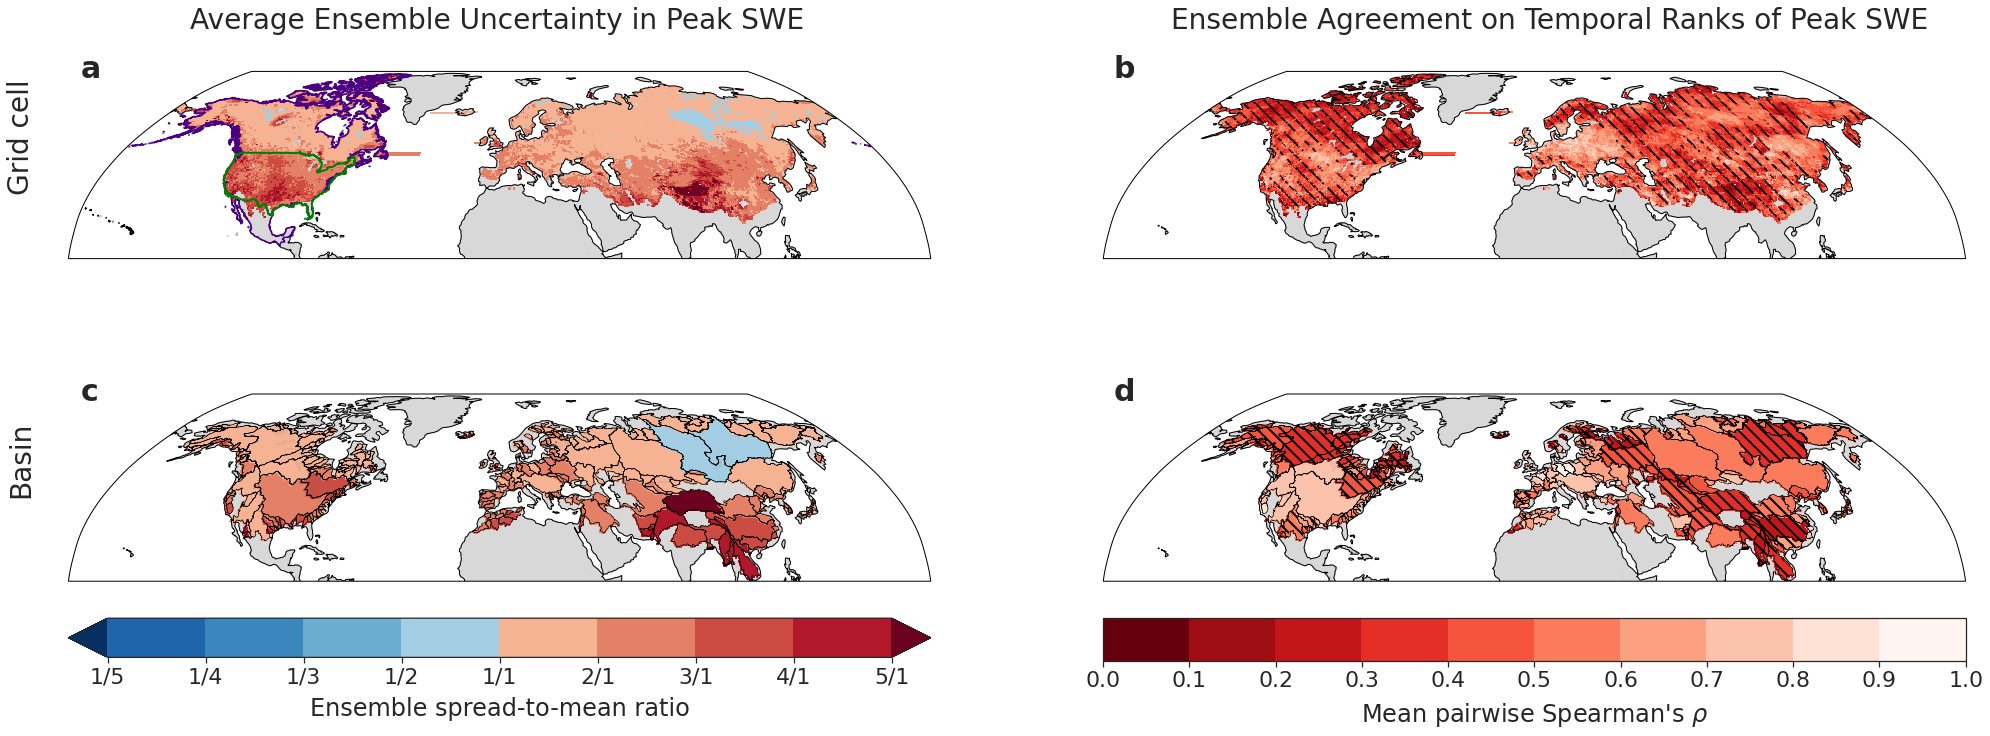

In [42]:
sns.set(font_scale=2, style="white")
mpl.rcParams['hatch.linewidth'] = 2
fig = plt.figure(figsize=(34,13.6))
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# binned colormap for uncertainty in magnitude
mag_cmap = plt.cm.get_cmap("RdBu_r")
mag_bounds = [1/5,1/4,1/3,1/2,1,2,3,4,5]
mag_colors = [mag_cmap(x) for x in [0.1,0.175,0.25,0.325,0.675,0.75,0.825,0.9]]
under = mag_cmap(0)
over = mag_cmap(0.99)
mag_cmap = mpl.colors.ListedColormap(mag_colors,name="mag_cmap")
mag_cmap.set_under(under)
mag_cmap.set_over(over)
mag_norm = mpl.colors.BoundaryNorm(boundaries=mag_bounds,ncolors=8)

# binned colormap for correlations
corr_cmap = plt.cm.get_cmap("Reds_r", 10)
corr_norm = mpl.colors.BoundaryNorm(np.arange(0,1.01,0.1),11)

# plot grid-cell uncertainty
ax1 = plt.subplot(gs[0,0],projection=ccrs.Robinson())
ax1.set_aspect("equal","box")
ax1.set_extent([-180,180,0,90], ccrs.PlateCarree())
gridded_ens_uncert.where(~xr.ufuncs.isnan(gridded_r_ds["r_mean"])).mean("time").plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=mag_cmap,norm=mag_norm, add_colorbar=False)
asp = ax1.get_aspect()
na_borders.geometry.boundary.plot(ax=ax1,transform=ccrs.PlateCarree(),color="indigo") # outline regions with different numbers of products
conus_borders.geometry.boundary.plot(ax=ax1,transform=ccrs.PlateCarree(),color="green",linewidth=2)
us_borders[us_borders.STUSPS=="HI"].geometry.boundary.plot(ax=ax1,transform=ccrs.PlateCarree(),color="black")
ax1.set_aspect(asp)

# plot basin-scale uncertainty
ax3 = plt.subplot(gs[1,0],projection=ccrs.Robinson())
basin_ens_uncert.where(~xr.ufuncs.isnan(basin_r_ds)).plot(ax=ax3, transform=ccrs.PlateCarree(), cmap=mag_cmap,norm=mag_norm, add_colorbar=False)
grdc_basins[grdc_basins.RIVER_BASI.isin(basin_r.RIVER_BASI)].geometry.boundary.plot(ax=ax3, transform=ccrs.PlateCarree(), color="black", lw=0.5) # add basin_outlines


# plot grid-cell mean of pairwise correlation distribution
ax2 = plt.subplot(gs[0,1],projection=ccrs.Robinson())
gridded_r_ds["r_mean"].plot(ax=ax2, transform=ccrs.PlateCarree(), cmap=corr_cmap,norm=corr_norm, add_colorbar=False)
gridded_r_ds["frac_sig"].plot.contourf(ax=ax2,transform=ccrs.PlateCarree(), colors="none",levels=[0,1/2,2],hatches=["\\\\",None],add_colorbar=False) # add hatching where fewer than half of correlations significant

# plot basin-scale uncertainty
ax4 = plt.subplot(gs[1,1],projection=ccrs.Robinson())
basin_r_ds.plot(ax=ax4, transform=ccrs.PlateCarree(), cmap=corr_cmap,norm=corr_norm, add_colorbar=False)
basin_r_sig.plot.contourf(ax=ax4, transform=ccrs.PlateCarree(), colors="none",levels=[0,1/2,2],hatches=["\\\\",None],add_colorbar=False)  # add hatching where fewer than half of correlations significant
grdc_basins[grdc_basins.RIVER_BASI.isin(basin_r.RIVER_BASI)].geometry.boundary.plot(ax=ax4, transform=ccrs.PlateCarree(), color="black", lw=0.5) # add basin_outlines


# add colorbar for uncertainty in magnitude
mag_sm = plt.cm.ScalarMappable(cmap=mag_cmap, norm=mag_norm)
mag_sm.set_array([])
mag_cbar = fig.colorbar(mag_sm, ax=[ax1, ax3], orientation="horizontal", ticks=mag_bounds, pad=0.05,use_gridspec=True, extend="both")
mag_cbar.ax.set_xlabel(r"Ensemble spread-to-mean ratio", labelpad=10)
mag_cbar.ax.set_xticklabels(["1/5","1/4","1/3","1/2","1/1","2/1","3/1","4/1","5/1"])
fig.text(0.13,0.79, "a",fontsize=30,fontweight="bold")
fig.text(0.13,0.46, "c",fontsize=30,fontweight="bold")

# add colorbar for average correlation
corr_sm = plt.cm.ScalarMappable(cmap=corr_cmap, norm=corr_norm)
corr_sm.set_array([])
corr_cbar = fig.colorbar(corr_sm, ax=[ax2, ax4], orientation="horizontal", ticks = np.arange(0,1.01,0.1), pad=0.05,use_gridspec=True)
corr_cbar.ax.set_xlabel(r"Mean pairwise Spearman's $\rho$", labelpad=10)
corr_cbar.ax.set_xticklabels([np.round(0.1*i,1) for i in range(11)])
fig.text(0.552,0.79, "b",fontsize=30,fontweight="bold")
fig.text(0.552,0.46, "d",fontsize=30,fontweight="bold")

fig.text(0.1, 0.73, "Grid cell", fontsize=28, rotation=90, va="center")
fig.text(0.1, 0.4, "Basin", fontsize=28, rotation=90, va="center")
fig.text(0.3, 0.84, "Average Ensemble Uncertainty in Peak SWE", fontsize=28, ha="center")
fig.text(0.73, 0.84, "Ensemble Agreement on Temporal Ranks of Peak SWE", fontsize=28, ha="center")

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_extent([-180,180,10,85], ccrs.PlateCarree())
    ax.coastlines('110m')
    ax.add_feature(cartopy.feature.OCEAN, facecolor="white")
    ax.add_feature(cartopy.feature.LAKES, facecolor="grey",alpha=0.1)
    ax.title.set_text("")
    ax.set_aspect("equal","box")
    ax.add_feature(cartopy.feature.LAND, facecolor="grey",alpha=0.3)

plt.savefig(os.path.join(fig_dir, "fig1.png"))